In [56]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn import metrics
import numpy as np
from collections import Counter
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
import models
import pickle as pkl
from tqdm import tqdm
import train
from style import *
from sklearn import decomposition
import viz

df = data_tracks.get_data(use_processed=True, use_processed_dicts=True) #use_processed=False, use_processed_dicts=True)
feat_names = data_tracks.get_feature_names(df)

# don't use dict_feats
feat_names = [x for x in feat_names 
              if not x.startswith('sc_') 
              and not x.startswith('nmf_')
              and not x in ['center_max', 'left_max', 'right_max', 'up_max', 'down_max']
              and not x.startswith('pc_')
#               and not 'slope' in x
             ]
print(feat_names)
print('num feats', len(feat_names))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['total_displacement', 'mean_square_displacement', 'lifetime', 'X_max', 'X_min', 'X_mean', 'X_std', 'X_peak_time_frac', 'slope_end', 'X_peak_last_15', 'X_peak_last_5', 'rise', 'fall', 'rise_slope', 'fall_slope', 'rise_local_3', 'fall_local_3', 'rise_local_11', 'fall_local_11', 'max_diff', 'min_diff', 'X_max_spl', 'dx_max_spl', 'd2x_max_spl', 'num_local_max_spl', 'num_local_min_spl', 'pc_0', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_7', 'pc_8', 'pc_9']
num feats 36


# loop over classifiers

In [59]:
outcome_def = 'y_consec_thresh'
# out_dir = f'results/outcome={outcome_def}'
out_dir = f'results/jan22_2'
os.makedirs(out_dir, exist_ok=True)
feature_selection_nums = [3, 5, 7, 15] #[3, 5, 7, 12, 16]: # number of feature to select [4, 9, 11, 23, 35, 39]
for feature_selection_num in feature_selection_nums:
    for feature_selection in ['select_rf', 'select_lasso', None]: # select_lasso, select_rf, None
        if feature_selection is None and feature_selection_num == feature_selection_nums[0]: # don't do extra computation
            for model_type in tqdm(['logistic', 'rf', 'mlp2', 'svm']): #,'gb', 'logistic', 'dt', 'svm', 'gb', rf', 'mlp2', 'irf']):
                for num_feats in [16, 25, len(feat_names)]: #[16, 25, len(feat_names)]: # number of total features to consider
                    for balancing in ['ros']: # None, ros                        
                        for balancing_ratio in [0.8, 1, 1.2]: # positive: negative                        
                            feats = feat_names[:num_feats]
                            out_name = f'{model_type}_{num_feats}_{balancing}={balancing_ratio}_{feature_selection}={feature_selection_num}'
                            train.train(df, feat_names=feats, model_type=model_type, 
                                        balancing=balancing, balancing_ratio=balancing_ratio,
                                        outcome_def=outcome_def,
                                        feature_selection=feature_selection,
                                        feature_selection_num=feature_selection_num,
                                        out_name=f'{out_dir}/{out_name}.pkl')

100%|██████████| 4/4 [04:23<00:00, 67.72s/it]


# dim reduction with classifier

In [3]:
# feats_to_reduce = feat_names[:11] 
feats_to_reduce = feat_names
X = df[feat_names]
X = (X - X.mean()) / X.std()

**look at pcs**

In [ ]:
# perform pca
pca = decomposition.PCA(whiten=True)
# pca = decomposition.SparsePCA()
# pca = decomposition.NMF()
pca.fit(X)
plt.figure(figsize=(6, 9), dpi=200)
viz.plot_pcs(pca, X)

In [ ]:
plt.figure(dpi=200)
ys_neg = df[outcome_def].values == 0
plt.plot(df['pc_0'][ys_neg], df['pc_1'][ys_neg], 'o', 
         color=cr, alpha=0.3, markeredgewidth=0, ms=2) #
plt.plot(df['pc_0'][~ys_neg], df['pc_1'][~ys_neg], 'o', 
         color=cb, alpha=0.3, markeredgewidth=0, ms=2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# feats

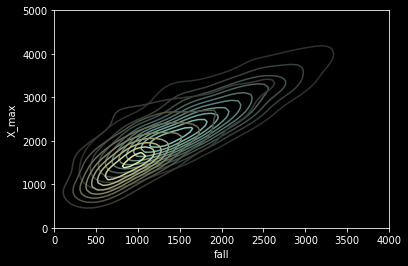

In [41]:
R, C = 1, 2
df_n = df[df[outcome_def]==0]
df_p = df[df[outcome_def]==1]
sns.kdeplot(df_p.fall, df_p.X_max) #, cmap="Blues", shade=False, shade_lowest=False) #, ax=ax)
sns.kdeplot(df_n.fall, df_n.X_max) #, cmap="Reds", shade=False, shade_lowest=False)

plt.xlim(0, 4000)
plt.ylim(0, 5000)
plt.savefig('feature_densities.pdf')
plt.show()
# plt.subplot(R, C, 1)
# sns.jointplot(x="fall", y="X_max", data=df[df[outcome_def]==0], kind='kde')
# plt.subplot(R, C, 2)
# sns.jointplot(x="fall", y="X_max", data=df[df[outcome_def]==1], kind='kde')

In [ ]:
g = sns.jointplot(x="fall", y="X_max", data=df, kind='kde')